In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 

In [2]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

LEARNING_RATE = 3e-2

NQ = 2
GIJS = False

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


# note that words labelled with '1', receive the label  |0> = [1,0]

train_labels, forget = read_data('../datasets/mc_train_data.txt')
test_labels, forget = read_data('../datasets/mc_test_data.txt')
val_labels, forget = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

if not GIJS: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if GIJS:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]




In [5]:
print(len(test_data))
print(len(train_data))
print(len(val_data))

print(test_labels)

30
70
30
[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


In [6]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [7]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



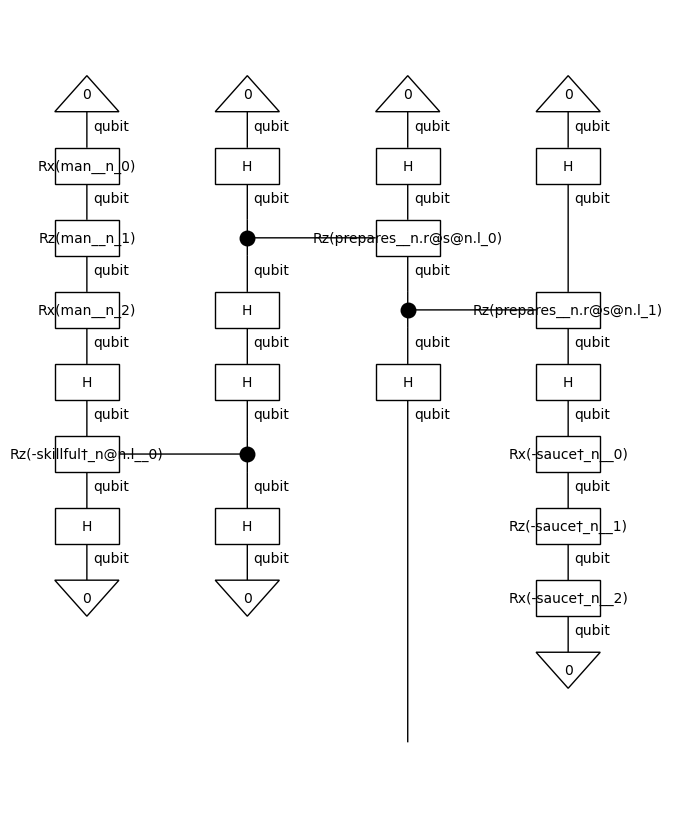

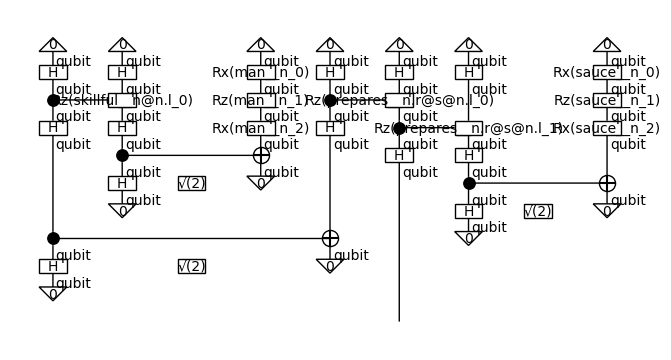

In [8]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=3, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

ansatz(raw_train_diagrams[0]).draw()


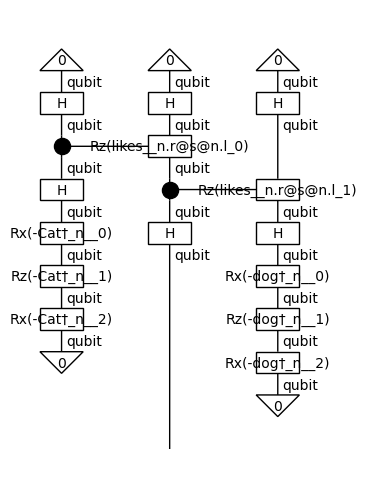

In [10]:
test = parser.sentence2diagram('Cat likes dog')
test = remove_cups(test)
testt = ansatz(test)
testt.draw()

In [56]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [57]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [58]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)


In [59]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [60]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.2968   valid/loss: 0.2891   train/acc: 0.5286   valid/acc: 0.4667
Epoch 2:    train/loss: 0.1379   valid/loss: 0.3237   train/acc: 0.6714   valid/acc: 0.4333
Epoch 3:    train/loss: 0.0890   valid/loss: 0.2776   train/acc: 0.8286   valid/acc: 0.5333
Epoch 4:    train/loss: 0.1972   valid/loss: 0.2262   train/acc: 0.8571   valid/acc: 0.6000
Epoch 5:    train/loss: 0.0267   valid/loss: 0.2098   train/acc: 0.8714   valid/acc: 0.6000
Epoch 6:    train/loss: 0.1297   valid/loss: 0.2194   train/acc: 0.8857   valid/acc: 0.6333
Epoch 7:    train/loss: 0.0377   valid/loss: 0.2601   train/acc: 0.8857   valid/acc: 0.5667
Epoch 8:    train/loss: 0.0561   valid/loss: 0.2691   train/acc: 0.9000   valid/acc: 0.6000
Epoch 9:    train/loss: 0.1479   valid/loss: 0.2635   train/acc: 0.9000   valid/acc: 0.6000
Epoch 10:   train/loss: 0.0634   valid/loss: 0.2513   train/acc: 0.9143   valid/acc: 0.6333
Epoch 11:   train/loss: 0.0836   valid/loss: 0.2750   train/acc: 0.9000   valid/

In [61]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [62]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.9269   valid/loss: 0.6845   train/acc: 0.5000   valid/acc: 0.5000
Epoch 2:    train/loss: 0.3493   valid/loss: 0.6660   train/acc: 0.6571   valid/acc: 0.5667
Epoch 3:    train/loss: 0.7114   valid/loss: 0.7298   train/acc: 0.6429   valid/acc: 0.6333
Epoch 4:    train/loss: 0.4779   valid/loss: 0.7644   train/acc: 0.6857   valid/acc: 0.5667
Epoch 5:    train/loss: 0.3943   valid/loss: 0.6511   train/acc: 0.6714   valid/acc: 0.6333


Epoch 6:    train/loss: 0.5053   valid/loss: 0.6511   train/acc: 0.7000   valid/acc: 0.6333
Epoch 7:    train/loss: 0.3534   valid/loss: 0.6316   train/acc: 0.7714   valid/acc: 0.6333
Epoch 8:    train/loss: 0.3655   valid/loss: 0.6239   train/acc: 0.7857   valid/acc: 0.6000
Epoch 9:    train/loss: 0.3295   valid/loss: 0.6461   train/acc: 0.7143   valid/acc: 0.6000
Epoch 10:   train/loss: 0.4723   valid/loss: 0.6719   train/acc: 0.7571   valid/acc: 0.6667
Epoch 11:   train/loss: 0.4226   valid/loss: 0.6666   train/acc: 0.7857   valid/acc: 0.6333
Epoch 12:   train/loss: 0.2033   valid/loss: 0.6715   train/acc: 0.7714   valid/acc: 0.6667
Epoch 13:   train/loss: 0.5595   valid/loss: 0.7157   train/acc: 0.7000   valid/acc: 0.6000
Epoch 14:   train/loss: 0.4705   valid/loss: 0.7210   train/acc: 0.7714   valid/acc: 0.7000
Epoch 15:   train/loss: 0.2652   valid/loss: 0.7264   train/acc: 0.7429   valid/acc: 0.7000
Epoch 16:   train/loss: 0.4491   valid/loss: 0.7145   train/acc: 0.7286   valid/

In [63]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.9142   valid/loss: 4.5688   train/acc: 0.5643   valid/acc: 0.7167
Epoch 2:    train/loss: 1.6540   valid/loss: 1.4060   train/acc: 0.4714   valid/acc: 0.5167
Epoch 3:    train/loss: 0.4623   valid/loss: 2.6150   train/acc: 0.6500   valid/acc: 0.5167
Epoch 4:    train/loss: 1.3578   valid/loss: 2.4160   train/acc: 0.6714   valid/acc: 0.7167
Epoch 5:    train/loss: 3.4234   valid/loss: 1.8823   train/acc: 0.6929   valid/acc: 0.5833
Epoch 6:    train/loss: 1.5077   valid/loss: 2.5612   train/acc: 0.6143   valid/acc: 0.6333
Epoch 7:    train/loss: 4.7786   valid/loss: 3.4523   train/acc: 0.6286   valid/acc: 0.5000
Epoch 8:    train/loss: 1.9784   valid/loss: 3.3367   train/acc: 0.5786   valid/acc: 0.5000
Epoch 9:    train/loss: 1.5946   valid/loss: 4.0862   train/acc: 0.5214   valid/acc: 0.5500
Epoch 10:   train/loss: 2.9696   valid/loss: 2.0623   train/acc: 0.5071   valid/acc: 0.5167
Epoch 11:   train/loss: 2.9289   valid/loss: 1.9590   train/acc: 0.4929   valid/

In [74]:
# specify model 
usedModel = 'tk'


if usedModel == 'tk':
    # The symbols are the names of the respective parameters for the respective words
    smbls = modelTK.symbols
    # And the weights are their respective values 
    weights = modelTK.weights
elif usedModel == 'np':
    smbls = modelNumpy.symbols
    weights = modelNumpy.weights
elif usedModel == 'pl':
    smbls = modelPennylane.symbols
    weights = modelPennylane.weights 


if usedModel != 'none':
    # create a simple dictionary for parameters and weights 
    parameterDict = {}
    for i in range(len(smbls)):
        parameterDict[str(smbls[i])] = weights[i].item()

    print(parameterDict)

    import pickle

    if GIJS:
        with open('../weights/weightsDict' + usedModel + str(NQ) + 'QB_' + str(EPOCHS) + '_gijs_' +  '.pkl', 'wb') as fp:
            pickle.dump(parameterDict, fp)
    if not GIJS: 
        with open('../weights/weightsDict' + usedModel + str(NQ) + 'QB_' + str(EPOCHS) + '_3layers.pkl', 'wb') as fp:
            pickle.dump(parameterDict, fp)

{'application__n_0': 0.453271910804372, 'application†_n__0': 0.4486241532987251, 'bakes__n.r@s@n.l_0': 0.40361880982133375, 'bakes__n.r@s@n.l_1': 0.8966791200529466, 'bakes__n.r@s@n.l_2': 0.35637057582573645, 'bakes__n.r@s@n.l_3': 0.5421626483355263, 'cooks__n.r@s@n.l_0': 1.0307219432554218, 'cooks__n.r@s@n.l_1': 0.5820877216935433, 'cooks__n.r@s@n.l_2': 1.1064075700590967, 'cooks__n.r@s@n.l_3': 0.8387479263275882, 'dinner__n_0': 0.7626857745868395, 'dinner†_n__0': 0.6809156301897669, 'man__n_0': 0.3101201591939345, 'man†_n__0': 1.1659247222402442, 'meal__n_0': 0.18124873114954668, 'meal†_n__0': -0.45041372495571275, 'person__n_0': -0.027977101856420678, 'person†_n__0': 0.5557023906076788, 'prepares__n.r@s@n.l_0': 0.4926247952588736, 'prepares__n.r@s@n.l_1': 0.8765927727211145, 'prepares__n.r@s@n.l_2': 0.6718676662385659, 'prepares__n.r@s@n.l_3': 0.6914772581185853, 'program__n_0': 0.34469417888784604, 'program†_n__0': 0.3817567385312047, 'reads__n.r@s@n.l_0': 0.22103400162289674, 'rea

In [75]:
# save the models parameters to pkl files 
usedModel = 'none'

# if usedModel != 'none':

    
#     # numpy 
#     model = modelNumpy
#     trainer = trainerNumpy
#     filename = '../modelParameters/NumpyModel2QB_500'
#     acc = accNP
#     model.load(trainer.log_dir + '/best_model.lt')
#     val_acc = acc(model(val_circuits), val_labels)

#     dump_data = {
#         'train_epoch_cost': trainer.train_epoch_costs,
#         'train_eval_results': trainer.train_eval_results['acc'],
#         'val_costs': trainer.val_costs, 
#         'val_eval_results': trainer.val_eval_results['acc'],
#         'test_acc': val_acc.item()
#     }
#     with open(filename+'.pkl', 'wb') as file_handle:
#         pickle.dump(dump_data, file_handle)




#     # tket
#     model = modelTK
#     trainer = trainerTK
#     filename = '../modelParameters/TKetModel2QB_500'
#     acc = accTK
#     model.load(trainer.log_dir + '/best_model.lt')
#     val_acc = acc(model(val_circuits), val_labels)

#     dump_data = {
#         'train_epoch_cost': trainer.train_epoch_costs,
#         'train_eval_results': trainer.train_eval_results['acc'],
#         'val_costs': trainer.val_costs, 
#         'val_eval_results': trainer.val_eval_results['acc'],
#         'test_acc': val_acc.item()
#     }
#     with open(filename+'.pkl', 'wb') as file_handle:
#         pickle.dump(dump_data, file_handle)







    # # pennylane 
    # model = modelPennylane
    # trainer = trainerPennylane
    # acc = accPL
    # filename = '../modelParameters/PennylaneModel2QB_500'
    # pred = model(test_circuits)
    # labels = torch.tensor(test_labels)

    # dump_data = {
    #     'train_epoch_cost': trainer.train_epoch_costs,
    #     'train_eval_results': trainer.train_eval_results['acc'],
    #     'val_costs': trainer.val_costs, 
    #     'val_eval_results': trainer.val_eval_results['acc'],
    #     'test_acc': acc(pred, labels)
    # }
    # with open(filename+'.pkl', 'wb') as file_handle:
    #     pickle.dump(dump_data, file_handle)

Final test accuracy: 0.0
Validation accuracy: 0.7833333333333333


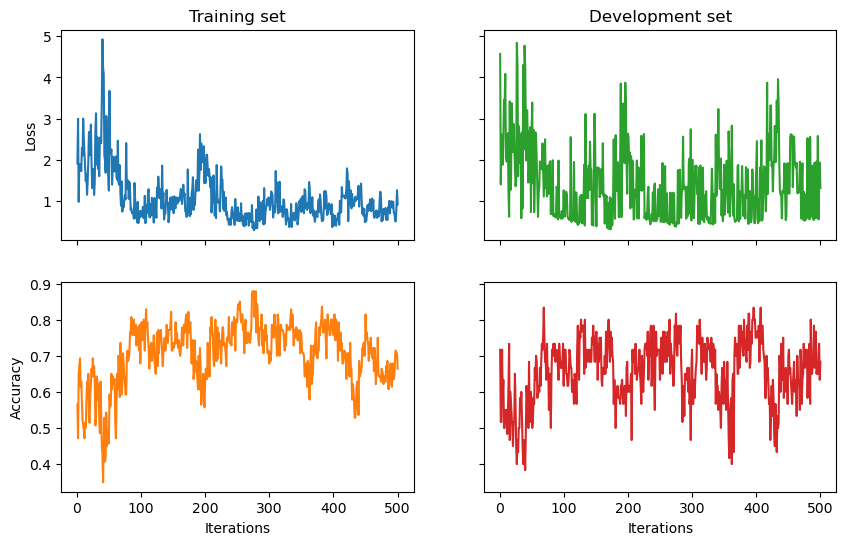

In [66]:
import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(test_circuits), test_labels)
print('Validation accuracy:', val_acc.item())

test_loss = BinaryCrossEntropyLoss()

In [67]:
'''
Now, for the density matrix part. 
We write a qiskit circuit and we predict, given the weights, the density matrices with the nouns missing
''' 
from qiskit import QuantumCircuit

# a = modelNumpy.get_diagram_output(test_circuits)
# print(len(a))

# print(a)

# print(len(test_circuits))
# print(len(pred))

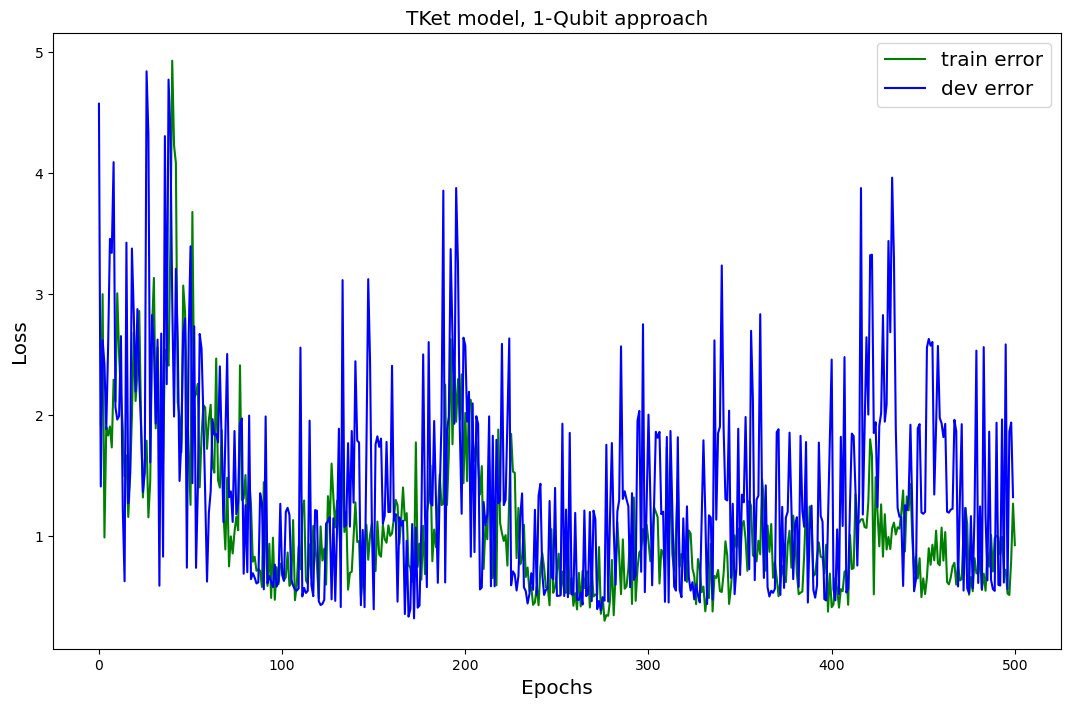

In [68]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

# ax1.plot(range_, trainer.train_epoch_costs, '-k', markersize=4, label='cost')
ax1.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
ax1.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
ax1.set_ylabel(r"Loss", fontsize='x-large')
ax1.set_xlabel(r"Epochs", fontsize='x-large')
# ax1.legend(loc='upper center', fontsize='x-large')

# ax2 = ax1.twinx()
# ax2.set_ylabel(r"Error in \%", fontsize='x-large')
# ax2.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
# ax2.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
# ax2.plot(range(len(trainer.train_costs)), trainer.train_costs, '-r', markersize=4, label='test error')
ax1.legend(loc='upper right', fontsize='x-large')


plt.title('TKet model, 1-Qubit approach', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()


In [69]:
def BCL(y_true, y_pred):
    '''
    Binary Cross Entropy Loss
    '''
    result = 0
    for i in range(len(y_true)):
        result += ( y_true[i] * np.log(y_pred[i]) + (1-y_true[i]) * np.log(1- y_pred[i]) )

    return ( - 1 / (len(y_true)) * result )  

In [70]:
'''
manipulate labels a little, convert back to original, 1-dim labels
'''
yPredNew = []
yTrueNew = []

for i in range(len(pred)): 

    yPred = pred[i]
    yTrue = test_labels[i]

    # only prob for the positive class 
    if yPred[0] < 1e-15:
        yPredNew.append(yPred[0] + 1e-15)
    elif yPred[0] > (1-(1e-15)): 
        yPredNew.append(yPred[0] - 1e-15)
    else: 
        yPredNew.append(yPred[0])

    # true label 
    if yTrue[1] > yTrue[0]:
        yTrueNew.append(1)
    else:
        yTrueNew.append(0)

print(yPredNew)
print(yTrueNew)
        
    
rs = BCL(yTrueNew, yPredNew)
print(rs)


[0.3333333333333333, 0.999999999999999, 0.4117647058823529, 0.7857142857142857, 0.999999999999999, 0.6730769230769231, 0.8181818181818182, 0.8888888888888888, 0.4294478527607362, 0.9811320754716981, 0.9777777777777777, 0.6947368421052632, 0.6428571428571429, 0.999999999999999, 0.9722222222222222, 0.32075471698113206, 0.1, 0.999999999999999, 0.3076923076923077, 0.75, 0.34210526315789475, 0.9811320754716981, 0.9555555555555556, 0.999999999999999, 0.6285714285714286, 0.96875, 0.16666666666666666, 0.9285714285714286, 0.45, 0.40476190476190477]
[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
5.905805006954444


In [71]:
np.log(0.0000001)

-16.11809565095832